In [0]:
import os
import sys
from matplotlib import pyplot as plt
import numpy as np
from datadrivenpdes.core import equations
from datadrivenpdes.core import grids
import datadrivenpdes as pde
import tensorflow as tf
tf.enable_eager_execution()
import xarray as xr

# First example: Advection diffusion

In this example we'll see how to integrate in time a pre-defined equation. Here we deal with the Advection-Diffusion equation, which describes the time evolution of the concentration $c(x,y,t)$ when it is advected by the velocity field $\vec v(x,y)=(v_x(x,y), v_y(x,y)$ and also undergoes diffusion. The equation reads
$$\frac{\partial c}{\partial t}+\vec{v}\cdot\vec{\nabla}c= D \nabla^2 c$$
where $D$ is the diffusion coefficient. The equation is implemented in various forms in the folder `advection/equations`. Here we choose the Finite Volume formulation.

In [0]:
equation = pde.advection.equations.FiniteVolumeAdvectionDiffusion(diffusion_coefficient=0.01)
grid = grids.Grid.from_period(size=256, length=2*np.pi)

Note that we also chose a grid to solve the equation on. The $x$ and $y$ coordinates can be obtained by

In [0]:
x, y = grid.get_mesh()

To integrate in time we need an initial state. Equations instances have a `random_state` method that generates a state. The distribution of these initial conditions, when sampled from different seeds, will define the training set for later. Let's sample one random initial state and plot it:

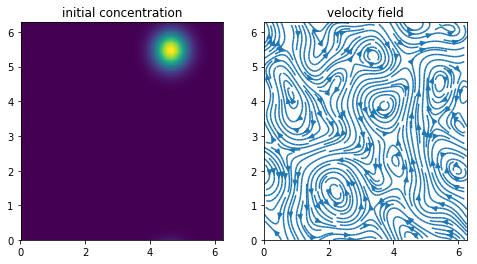

In [0]:
initial_state = equation.random_state(grid, seed=7109179)
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].pcolor(grid.get_mesh()[1],
              grid.get_mesh()[0],
              initial_state['concentration'])
axs[0].set_title('initial concentration')

axs[1].streamplot(grid.get_mesh()[1],
                  grid.get_mesh()[0],
                  initial_state['y_velocity'],initial_state['x_velocity'],
                  density=2)
axs[1].set_title('velocity field');

The state of an equation is a `dict` object that contains all relevant fields needed for integrating in time. For advection diffusion these are `concentration`, `x_velocity`, and  `y_velocity`:

In [0]:
print(initial_state.keys())

dict_keys(['concentration', 'x_velocity', 'y_velocity'])


To perform the actual integration we need to choose a method with which to estimate the spatial derivatives of the concentration $c$. The object which estimates the derivatives is called a `model` and there are various models defined in `models.py`. Here we will use a finite difference estimation. Lastly, we need to choose a timestep, which we can ask the equation instance to supply.

In [0]:
time_step = equation.get_time_step(grid)
times = time_step*np.arange(400)
results = pde.core.integrate.integrate_times(
    model=pde.core.models.FiniteDifferenceModel(equation,grid),
    state=initial_state,
    times=times, axis=0)

The result is a `dict` object. The `concentration` member of the dict is a tensor whose first axis corresponds to the times at which the solution was evaluated. Here we save the result as an `xarray.DataArray`, which makes it easy to plot.

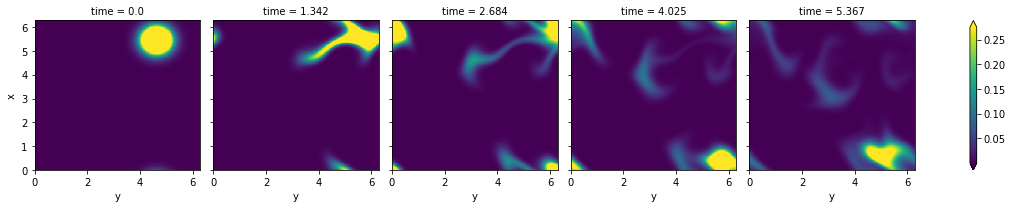

In [0]:
conc=xr.DataArray(results['concentration'].numpy(),
                  dims=['time', 'x','y'],
                  coords={'time':times, 'x': x[:,0], 'y': y[0]}
                 )
conc[::99].plot(col='time', robust=True, aspect=1)

# Defining a new equation

In this section we learn how to define a new equation. We will look at coupled reaction diffusion equations, aka the **Turing Equation**. They decscribe the evolution of two fields, $A$ and $B$, according to:
$$\begin{align}
\frac{\partial A}{\partial t} &= D_A\nabla^2 A + R_A(A,B)+S\\
\frac{\partial B}{\partial t} &= D_B\nabla^2 B + R_B(A,B)
\end{align}$$
$D_{A,B}$ are the diffusion constants of $A$ and $B$, $R_{A,B}$ are nonlinear reaction terms and $S$ is some constant source term. For example, we'll take
$$\begin{align}
R_A&=A(1-A^2)-\alpha B & 
R_B&=\beta(A-B)
\end{align}$$
where $\alpha$ and $\beta$ are model parameters. For simplicity, we'll implelment the equation in one spatial dimension. 

## Equation Keys
Because the computational framework is [fully differentiable](https://en.wikipedia.org/wiki/Differentiable_programming), defining an equation requires specifiying in advance what are the quantities that are used in calcualting time derivatives. These are called **keys** and are stored in the `equation` attribute `key_definitions`. In our case, to calculate the time evolution we need $A, B, \partial_{xx}A, \partial_{xx}B $ and $S$.

The auxilliary function `states.StateDefinition` defines these keys. Its input arguments are:
* `name` - The base name of the field. For example, the field $\partial_{xx} A$ is derived from the base field `A`.
* `tensor_indices` - In 2D and above, specify whether a field is a component of a tensor (like $v_x$ and $v_y$ in the advection example).
* `derivative_orders` - Specifies whether a key is a spatial derivative of a different key.
* `offset` - Specifies whether a field is evaluated off the center point of a grid (useful for staggered grids, e.g. finite volume schemes)

For example, in our case the `key_definitions` for $A$ and $\partial_{xx}A$ are

```python
key_definitions = {
    'A': states.StateDefinition(name='A',     
                  tensor_indices=(),          # Not used in one dimenional equations
                  derivative_orders=(0,0,0),  # A is not a derivative of anything else
                  offset=(0,0)),              # A is evaluated on the centerpoints of the grid
    
    'A_xx': states.StateDefinition(name='A',       # A_xx is is derived from A
                     tensor_indices=(),
                     derivative_orders=(2, 0, 0),  # Two derivatives on the x axis
                     offset=(0, 0)),               
  }
```
There are two types of keys: those that evolve in time, in our case $A$ and $B$, and constant ones, in our case $S$ (and in the Advection Diffusion example - the velocity field $v$). When defining the equation we need to set the attributes `evolving_keys` and `constant_keys`, which are both python `set`s. 

The different keys of an `Equation` instance can be inspected with
```python
equation.all_keys        # in our case: {'A', 'A_xx', 'B', 'B_xx', 'Source'}
equation.base_keys       # in our case: {'A', 'B', 'Source'}
equation.evolving_keys   # in our case: {'A', 'B'}
equation.constant_keys   # in our case: {'Source'}
```


## Defining the equation

Here is a full definition of the equation:

In [0]:
from datadrivenpdes.core import equations
from datadrivenpdes.core import grids
from datadrivenpdes.core import polynomials
from datadrivenpdes.core import states
import scipy as sp


def smooth_random_field(N, amp=0.1, np_random_state=None):
    """
    generates a random field of shape (N,1) and smoothes it a bit
    """
    if np_random_state is None:
      np_random_state = np.random.RandomState()
    noise=np_random_state.randn(N)  
    kernel=np.exp(-np.linspace(-6,6,N)**2)  
    return amp*sp.ndimage.convolve(noise, kernel, mode='wrap')[:,np.newaxis]

class TuringEquation(equations.Equation):

    DISCRETIZATION_NAME = 'finite_difference'
    METHOD = polynomials.Method.FINITE_DIFFERENCE
    MONOTONIC = False
    CONTINUOUS_EQUATION_NAME = 'Turing'

    key_definitions = {
        'A': states.StateDefinition(name='A',
                      tensor_indices=(),
                      derivative_orders=(0,0,0),
                      offset=(0,0)),
        'A_xx': states.StateDefinition(name='A',
                         tensor_indices=(),
                         derivative_orders=(2, 0, 0),
                         offset=(0, 0)),
        'B': states.StateDefinition(name='B',
                      tensor_indices=(),
                      derivative_orders=(0, 0, 0),
                      offset=(0, 0)),
        'B_xx': states.StateDefinition(name='B',
                         tensor_indices=(),
                         derivative_orders=(2, 0, 0),
                         offset=(0, 0)),
        'Source' : states.StateDefinition(name='Source',
                         tensor_indices=(),
                         derivative_orders=(0, 0, 0),
                         offset=(0, 0)),
    }
    evolving_keys = {'A', 'B'}
    constant_keys = {'Source'}

    def __init__(self, alpha, beta, D_A, D_B, timestep=1e-4):
        self.alpha = alpha
        self.beta = beta
        self.D_A = D_A
        self.D_B = D_B
        self._timestep = timestep
        super().__init__()
    
    def time_derivative(
          self, grid, A, A_xx, B, B_xx, Source):
        """See base class."""
        rA = self.reaction_A(A, B)
        rB = self.reaction_B(A, B)
        diff_A = self.D_A * A_xx
        diff_B = self.D_B * B_xx
        return {'A': rA + diff_A + Source,
                'B': rB + diff_B,}

    def reaction_A(self, A, B):
        return A - (A ** 3) - B + self.alpha

    def reaction_B(self, A, B):
        return (A - B) * self.beta

    def get_time_step(self, grid):
        return self._timestep

    def random_state(self, grid, seed=None, dtype=tf.float32):
        if seed is None:
            R = np.random.RandomState()
        else:
            R = np.random.RandomState(seed=seed)

        state = {
          'A': smooth_random_field(N=grid.size_x, np_random_state=R),
          'B': smooth_random_field(N=grid.size_x, np_random_state=R),
          'Source': smooth_random_field(N=grid.size_x, np_random_state=R),
        }

        state = {k: tf.cast(v, dtype) for k, v in state.items()}
        return state

Now we can generate a random state and evolve it in time

In [0]:
eq = TuringEquation(alpha=-0.0001, beta=10, D_A=1, D_B=30)
NX=100
NY=1 # 1D can be obtained by haveing a y dimension of size 1
LX=200
grid = grids.Grid(NX, NY, step=LX/NX)
x, y=grid.get_mesh()

initial_state = eq.random_state(grid=grid, seed=12345)
times = eq._timestep*np.arange(0, 1000, 20)
model = pde.core.models.FiniteDifferenceModel(eq,grid)
res = pde.core.integrate.integrate_times(
    model=model,
    state=initial_state,
    times=times, axis=0)

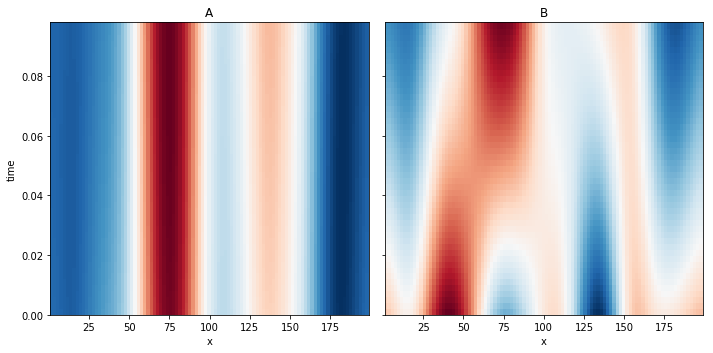

In [0]:
fig, axs=plt.subplots(1,2, figsize=(10,5), sharey=True)
for ax, k in zip(axs, ['A','B']):
    ax.pcolormesh(x.flat, times, res[k].numpy()[...,0], cmap='RdBu')
    ax.set_title(k)
    ax.set_xlabel('x')
axs[0].set_ylabel('time')
fig.tight_layout()